# Image Encryption with Linear Feedback Shift Register (LFSR)
This notebook demonstrates how to encrypt and decrypt images using LFSR-based cryptography, applying Shannon's principles of confusion and diffusion.

### Import Required Libraries


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

### LFSR Cipher Implementation

In [2]:
class LFSRCipher:
    def __init__(self, seed, tap_positions):
        self.register = seed
        self.tap_positions = tap_positions
        self.size = max(tap_positions) + 1
        self.mask = (1 << self.size) - 1
    
    def next_bit(self):

        # Calculate feedback bit by XORing tapped bits
        feedback = 0
        for pos in self.tap_positions:
            feedback ^= (self.register >> pos) & 1
        
        # Shift register and add feedback bit
        self.register = ((self.register << 1) | feedback) & self.mask
        return feedback
    
    def generate_keystream(self, length):
        keystream = np.zeros(length, dtype=np.uint8)
        for i in range(length):
            # Collect 8 bits to form one byte
            byte = 0
            for j in range(8):
                byte = (byte << 1) | self.next_bit()
            keystream[i] = byte
        return keystream


### Confusion Layer

In [3]:
def apply_confusion(image, keystream):
    # Reshape keystream to match image dimensions (including RGB channels)
    keystream_resized = np.resize(keystream, image.size)
    keystream_3d = keystream_resized.reshape(image.shape)
    
    # Apply substitution (XOR operation)
    confused_image = np.bitwise_xor(image, keystream_3d)
    return confused_image

### Diffusion Layer

In [4]:
def apply_diffusion(image, lfsr):
    height, width, channels = image.shape
    size = height * width
    
    # Generate permutation indices for pixel positions
    # (we'll keep RGB channels together for each pixel)
    indices = np.arange(size)
    
    # Fisher-Yates shuffle using LFSR values
    for i in range(size - 1, 0, -1):
        # Use LFSR to generate random index j where 0 <= j <= i
        j = int(lfsr.generate_keystream(1)[0] / 255 * i)
        indices[i], indices[j] = indices[j], indices[i]
    
    # Reshape the image to separate pixels and channels
    flat_image = image.reshape(size, channels)
    diffused_flat = np.zeros_like(flat_image)
    
    for i, idx in enumerate(indices):
        diffused_flat[i] = flat_image[idx]
    
    # Reshape back to the original image dimensions
    diffused_image = diffused_flat.reshape(height, width, channels)
    return diffused_image, indices

### Reverse Diffusion

In [5]:
def reverse_diffusion(image, indices):
    height, width, channels = image.shape
    size = height * width
    
    # Create inverse mapping
    inverse_indices = np.zeros(size, dtype=np.int32)
    for i, idx in enumerate(indices):
        inverse_indices[idx] = i
    
    # Apply inverse permutation
    flat_image = image.reshape(size, channels)
    restored_flat = np.zeros_like(flat_image)
    
    for i, idx in enumerate(inverse_indices):
        restored_flat[i] = flat_image[idx]
    
    # Reshape back to the original dimensions
    restored_image = restored_flat.reshape(height, width, channels)
    return restored_image

###  Encryption Process

In [6]:
def encrypt_image(image_path, seed, tap_positions):
    # Load image in RGB mode
    img = Image.open(image_path).convert('RGB')
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Create LFSR for confusion
    lfsr_confusion = LFSRCipher(seed, tap_positions)
    keystream = lfsr_confusion.generate_keystream(img_array.size)
    
    # Apply confusion
    confused_img = apply_confusion(img_array, keystream)
    
    # Create new LFSR for diffusion with different seed
    lfsr_diffusion = LFSRCipher(seed ^ 0xA5A5A5, tap_positions)
    
    # Apply diffusion
    encrypted_img, indices = apply_diffusion(confused_img, lfsr_diffusion)
    
    
    return encrypted_img, indices

### Decryption Process

In [7]:
def decrypt_image(encrypted_img, indices, seed, tap_positions):
    # Reverse diffusion
    undiffused_img = reverse_diffusion(encrypted_img, indices)
    
    # Create LFSR with same parameters as encryption
    lfsr_confusion = LFSRCipher(seed, tap_positions)
    keystream = lfsr_confusion.generate_keystream(encrypted_img.size)
    
    # Reverse confusion (XOR operation is its own inverse with same key)
    decrypted_img = apply_confusion(undiffused_img, keystream)
    
    
    return decrypted_img

### Visualization Function

In [8]:
def display_images(original, encrypted, decrypted):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)  # No cmap for RGB
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(encrypted)
    plt.title('Encrypted Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(decrypted)
    plt.title('Decrypted Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


### Example 1: Lena Image

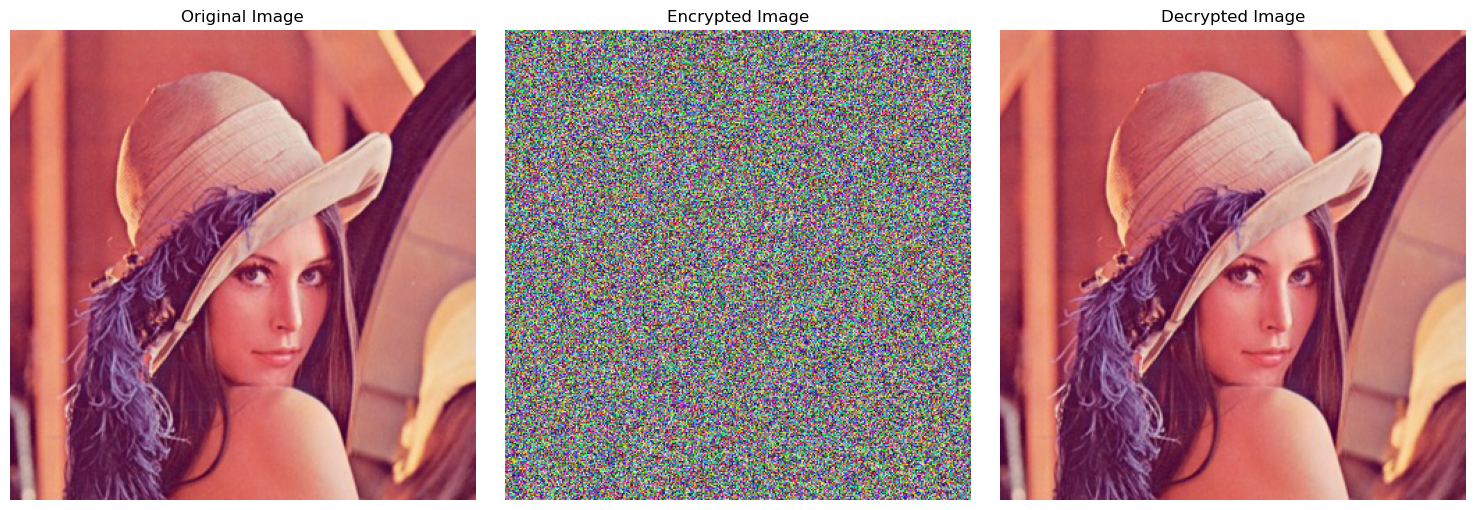

Encryption and decryption completed.


In [9]:
# File paths
image_path = "../data/lena.jpg"
# LFSR parameters
seed = 0xACE1  # Example seed
tap_positions = [16, 14, 13, 11]  # Example tap positions for a 16-bit LFSR

# Load original image for display
original_img = np.array(Image.open(image_path).convert('RGB'))

# Encrypt image
encrypted_img, indices = encrypt_image(image_path, seed, tap_positions)

# Decrypt image
decrypted_img = decrypt_image(encrypted_img, indices, seed, tap_positions)

# Display results
display_images(original_img, encrypted_img, decrypted_img)

print(f"Encryption and decryption completed.")

### Example 2:

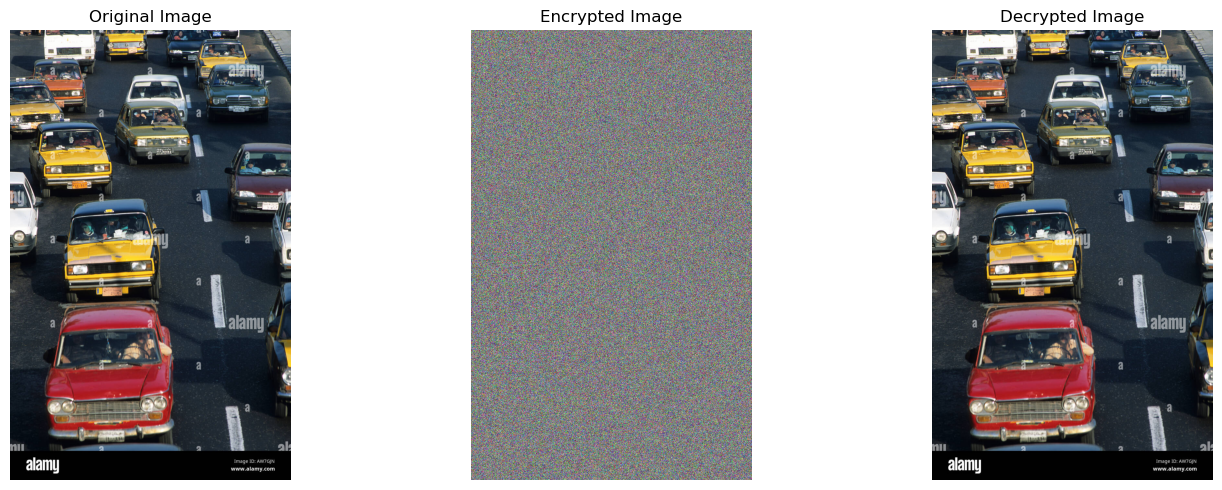

Encryption and decryption completed.


In [13]:
# File paths
image_path = "../data/test5.jpg"
# LFSR parameters
seed = 0xACE1  # Example seed
tap_positions = [16, 14, 13, 11]  # Example tap positions for a 16-bit LFSR

# Load original image for display
original_img = np.array(Image.open(image_path).convert('RGB'))

# Encrypt image
encrypted_img, indices = encrypt_image(image_path, seed, tap_positions)

# Decrypt image
decrypted_img = decrypt_image(encrypted_img, indices, seed, tap_positions)

# Display results
display_images(original_img, encrypted_img, decrypted_img)

print(f"Encryption and decryption completed.")